## Exploratory Data Analysis on the Full Train Data

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

In [3]:
globalstart = datetime.now()

In [4]:
raw_data_path = "./data/raw"
movie_titles_csv_path = raw_data_path + "/movie_titles.csv"

processed_data_path = "./data/processed"
models_path = "./models"
master_data_csv_path = processed_data_path + "/" + "data.csv"

In [5]:
train_df = pd.read_csv(processed_data_path + "/" + "train.csv", parse_dates=['date'])
test_df = pd.read_csv(processed_data_path + "/" + "test.csv")

## Basic Statistics

### Basic Statistics in Train data

In [6]:
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

Training data 
--------------------------------------------------

Total no of ratings : 80384405
Total No of Users   : 405041
Total No of movies  : 17424


### Basic Statistics in Test data

In [7]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

Test data 
--------------------------------------------------

Total no of ratings : 20096102
Total No of Users   : 349312
Total No of movies  : 17757


## Exploratory Data Analysis on Train data

In [8]:
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

### Distribution of ratings

In [9]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

/Users/vazkenabdulian/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-9-44ff7119eb75>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])


<IPython.core.display.Javascript object>

<p style="font-size:13px"> <b>Add new column (week day) to the data set  for analysis.</b></p>

In [10]:
pd.options.mode.chained_assignment = None  
train_df['date'] = pd.to_datetime(train_df['date'] , format="%Y/%m/%d")
train_df['day_of_week'] = train_df.date.dt.weekday

train_df.tail()

,movie,user,rating,date,day_of_week
80384400,12074,2033618,4,2005-08-08,0
80384401,862,1797061,3,2005-08-08,0
80384402,10986,1498715,5,2005-08-08,0
80384403,14861,500016,4,2005-08-08,0
80384404,5926,1044015,5,2005-08-08,0


### Number of Ratings per a month

In [11]:
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

<ipython-input-11-951422f262d9>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])


<IPython.core.display.Javascript object>

### Analysis on the Ratings given by user

In [12]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

In [13]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

<IPython.core.display.Javascript object>

In [14]:
no_of_rated_movies_per_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

> _There,  is something interesting going on with the quantiles.._

In [15]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

In [16]:
plt.title("Quantiles and their Values")
quantiles.plot()

plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")

plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')


plt.show()

<ipython-input-16-9c4bf65697c1>:12: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)


<IPython.core.display.Javascript object>

In [17]:
quantiles[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: rating, dtype: int64

__how many ratings at the last 5% of all ratings__??

In [18]:
print('\n No of ratings at last 5 percentile : {}\n'.format(sum(no_of_rated_movies_per_user>= 749)) )


 No of ratings at last 5 percentile : 20305



### Analysis of ratings of a movie given by a user

In [19]:
no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

<IPython.core.display.Javascript object>

### Number of ratings on each day of the week

In [20]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_df, ax=ax)
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

<ipython-input-20-072433654e13>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])


<IPython.core.display.Javascript object>

In [21]:
start = datetime.now()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating', x='day_of_week', data=train_df)
plt.show()
print(datetime.now() - start)

<IPython.core.display.Javascript object>

0:00:09.504106


In [22]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print(" AVerage ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 AVerage ratings
------------------------------
day_of_week
0    3.577250
1    3.574438
2    3.583751
3    3.582463
4    3.585274
5    3.591791
6    3.594144
Name: rating, dtype: float64




## Dealing with Sparse Matrices

### Understanding sparse matrix

In [23]:
train_df.user.values.shape, train_df.movie.values.shape, train_df.rating.values.shape

((80384405,), (80384405,), (80384405,))

In [24]:
row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])

sparse.csr_matrix((data, (row, col)),).toarray()


array([[1, 0, 2],
       [0, 0, 3],
       [4, 5, 6]])

In [25]:
row, col, data

(array([0, 0, 1, 2, 2, 2]),
 array([0, 2, 2, 0, 1, 2]),
 array([1, 2, 3, 4, 5, 6]))

### Creating sparse matrix from train data frame

In [28]:
start = datetime.now()
if os.path.isfile(models_path + '/' + 'train_full_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
   
    train_sparse_matrix = sparse.load_npz(models_path + '/' + 'train_full_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),)
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    
    sparse.save_npz(models_path + '/' + "train_full_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')

print("Time taken: ", datetime.now() - start)


It is present in your pwd, getting it from disk....
DONE..
Time taken:  0:00:03.149752


<p><b>The Sparsity of Train Sparse Matrix</b></p>

In [29]:
train_sparse_matrix.shape

(2649430, 17771)

In [30]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.8292709259195 % 


### Creating sparse matrix from test data frame

In [31]:
start = datetime.now()
if os.path.isfile(models_path + '/' + 'test_full_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    
    test_sparse_matrix = sparse.load_npz(models_path + '/' + 'test_full_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    
    sparse.save_npz(models_path + '/' + "test_full_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')
    
print("Time taken: ", datetime.now() - start)


It is present in your pwd, getting it from disk....
DONE..
Time taken:  0:00:00.827693


<p><b>The Sparsity of Test data Matrix</b></p>

In [32]:
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.95731772988694 % 


## Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

In [33]:
def get_average_ratings(sparse_matrix, of_users):
    
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    is_rated = sparse_matrix!=0
    no_of_ratings = is_rated.sum(axis=ax).A1
    u,m = sparse_matrix.shape
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    return average_ratings

### finding global average of all movie ratings

In [34]:
train_averages = dict()

train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.582890686321557}

### finding average rating per user

In [35]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])


Average rating of user 10 : 3.3781094527363185


### finding average rating per movie

In [36]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15 :',train_averages['movie'][15])


 AVerage rating of movie 15 : 3.3038461538461537


### PDF's & CDF's of Avg.Ratings of Users & Movies (In Train Data)

/Users/vazkenabdulian/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/vazkenabdulian/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/vazkenabdulian/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displ

<IPython.core.display.Javascript object>


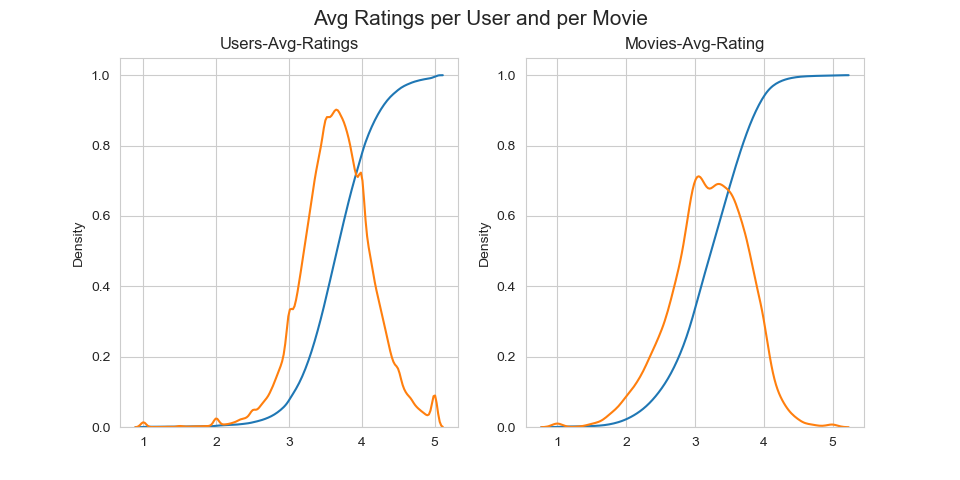

Time Taken: 0:00:03.914630


In [37]:
start = datetime.now()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

ax1.set_title('Users-Avg-Ratings')

user_averages = [rat for rat in train_averages['user'].values()]
sns.distplot(user_averages, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(user_averages, ax=ax1, hist=False,label='Pdf')

ax2.set_title('Movies-Avg-Rating')

movie_averages = [rat for rat in train_averages['movie'].values()]
sns.distplot(movie_averages, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(movie_averages, ax=ax2, hist=False, label='Pdf')

plt.show()
print("Time Taken:", datetime.now() - start)

## Analysis of Cold Start problem

### 1. Cold Start problem with Users

In [38]:
master_data_csv_path = processed_data_path + "/" + "data.csv"

In [39]:
start = datetime.now()


print("creating the dataframe from data.csv file..")
df = pd.read_csv(master_data_csv_path, sep=',', names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

print("Time Taken in Step1:", datetime.now() - start) # Time Taken in Step1: 0:01:16.501948


creating the dataframe from data.csv file..
Done.

Time Taken in Step1: 0:00:43.449782


In [40]:
df.head(2)

,movie,user,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13


In [41]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 480189

Number of Users in Train data : 405041

No of Users that didn't appear in train data: 75148(15.65 %) 
 


### 2. Cold Start problem with Movies

In [42]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 17770

Number of Users in Train data : 17424

No of Movies that didn't appear in train data: 346(1.95 %) 
 


In [43]:
print("Total Time taken :",datetime.now()-globalstart)

Total Time taken : 0:04:30.913491
